
# Log Analysis: Exploration Notebook

Use this notebook to explore the JSON/CSV outputs generated by `src/log_analyzer.py`.
It will automatically find the **latest** report in `../reports/`, load alerts & events,
and produce a few quick visualizations.

> Tips:
> - Run cells top‑to‑bottom after you've generated new reports.
> - If you only wrote **JSON** (no CSV), this notebook still works.


In [1]:

# === Setup ===
import json, ast
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# --- Local helper to show DataFrames ---
from IPython.display import display, HTML

def display_dataframe_to_user(title: str, df):
    """Render a titled DataFrame nicely in Jupyter."""
    display(HTML(f"<h3 style='margin-top:1rem'>{title}</h3>"))
    display(df)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

REPORTS_DIR = Path("../reports")

def _parse_timestamp_from_stem(stem: str):
    # stem looks like: report_YYYYMMDD_HHMMSS
    try:
        ts = stem.split("report_")[1]
        return datetime.strptime(ts, "%Y%m%d_%H%M%S")
    except Exception:
        return None

def latest_report_base():
    """Return Path to latest 'report_YYYYMMDD_HHMMSS' base (without extension)."""
    if not REPORTS_DIR.exists():
        return None
    candidates = sorted(
        [p for p in REPORTS_DIR.glob("report_*")],
        key=lambda p: (_parse_timestamp_from_stem(p.stem.split("_alerts")[0].split("_events")[0].split(".json")[0]) or datetime.min)
    )
    if not candidates:
        return None
    last = candidates[-1]
    stem = last.stem
    if stem.endswith("_alerts") or stem.endswith("_events"):
        stem = stem.rsplit("_", 1)[0]
    return REPORTS_DIR / stem

base = latest_report_base()
base


PosixPath('../reports/report_20251023_201636')

In [2]:

# === Load alerts & events (CSV if present, else JSON) ===
alerts_csv = (base.parent / f"{base.name}_alerts.csv") if base else None
events_csv = (base.parent / f"{base.name}_events.csv") if base else None
json_path  = (base.with_suffix(".json")) if base else None

df_alerts = pd.DataFrame()
df_events = pd.DataFrame()

if base is None:
    print("No reports directory or files found. Generate reports and re-run.")
else:
    if alerts_csv and alerts_csv.exists():
        df_alerts = pd.read_csv(alerts_csv)
    if events_csv and events_csv.exists():
        df_events = pd.read_csv(events_csv)
    if (df_alerts.empty or df_events.empty) and json_path and json_path.exists():
        import json
        with open(json_path, "r") as f:
            data = json.load(f)
        if df_alerts.empty and "alerts" in data:
            df_alerts = pd.DataFrame(data["alerts"])
        if df_events.empty and "events" in data:
            df_events = pd.DataFrame(data["events"])

# Normalize
if "start" in df_alerts.columns:
    df_alerts["start_dt"] = pd.to_datetime(df_alerts["start"], errors="coerce")

# Convert stringified lists to lists (CSV case)
import ast
if "unique_ips" in df_alerts.columns and df_alerts["unique_ips"].dtype == object:
    def _maybe_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return [x]
        return []
    df_alerts["unique_ips"] = df_alerts["unique_ips"].apply(_maybe_list)

if "ip_origins" in df_alerts.columns and df_alerts["ip_origins"].dtype == object:
    def _maybe_list_dicts(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        return []
    df_alerts["ip_origins"] = df_alerts["ip_origins"].apply(_maybe_list_dicts)

base, df_alerts.head(), df_events.head()


(PosixPath('../reports/report_20251023_201636'),
             rule                start  count                  unique_ips  window_sec  \
 0  failed_logins  2025-10-14T12:01:10      3  [192.0.2.45, 203.0.113.10]          60   
 1  failed_logins  2025-10-14T12:01:12      2              [203.0.113.10]          60   
 2  failed_logins  2025-10-14T12:01:15      1              [203.0.113.10]          60   
 3  failed_logins  2025-10-14T12:03:10      1             [198.51.100.33]          60   
 4         errors  2025-10-14T12:03:45      2                          []          60   
 
                                           ip_origins            start_dt  
 0  [{'ip': '192.0.2.45', 'origin': 'unknown'}, {'... 2025-10-14 12:01:10  
 1      [{'ip': '203.0.113.10', 'origin': 'unknown'}] 2025-10-14 12:01:12  
 2      [{'ip': '203.0.113.10', 'origin': 'unknown'}] 2025-10-14 12:01:15  
 3     [{'ip': '198.51.100.33', 'origin': 'unknown'}] 2025-10-14 12:03:10  
 4                                 

In [3]:

# === Quick summaries ===

if not df_alerts.empty:
    by_rule = df_alerts.groupby("rule", dropna=False)["count"].sum().reset_index().sort_values("count", ascending=False)
    display_dataframe_to_user("Alert counts by rule", by_rule)
else:
    print("No alerts loaded.")

if not df_events.empty:
    cols = [c for c in ["ts", "user", "ip", "status", "msg", "type"] if c in df_events.columns]
    display_dataframe_to_user("Sample of events", df_events[cols].head(25) if cols else df_events.head(25))
else:
    print("No events loaded.")


,rule,count
1,failed_logins,7
0,errors,4


,ts,user,ip,msg
0,2025-10-14T12:01:10,admin,192.0.2.45,NaN
1,2025-10-14T12:01:12,root,203.0.113.10,NaN
2,2025-10-14T12:01:15,root,203.0.113.10,NaN
3,2025-10-14T12:03:10,guest,198.51.100.33,NaN
4,2025-10-14T12:03:45,NaN,NaN,database connection timeout
5,2025-10-14T12:04:01,NaN,NaN,database connection timeout
6,2025-10-14T12:05:05,NaN,NaN,database connection timeout


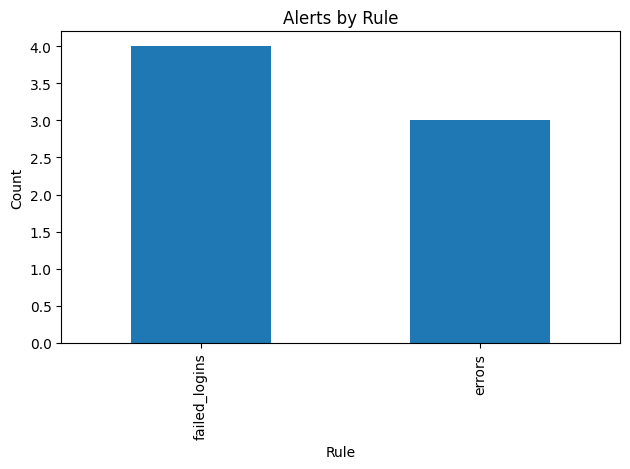

In [4]:

# === Visualization: Alerts by rule ===
if not df_alerts.empty and "rule" in df_alerts.columns:
    counts = df_alerts["rule"].value_counts().sort_values(ascending=False)
    plt.figure()
    counts.plot(kind="bar")
    plt.title("Alerts by Rule")
    plt.xlabel("Rule")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for Alerts by Rule.")


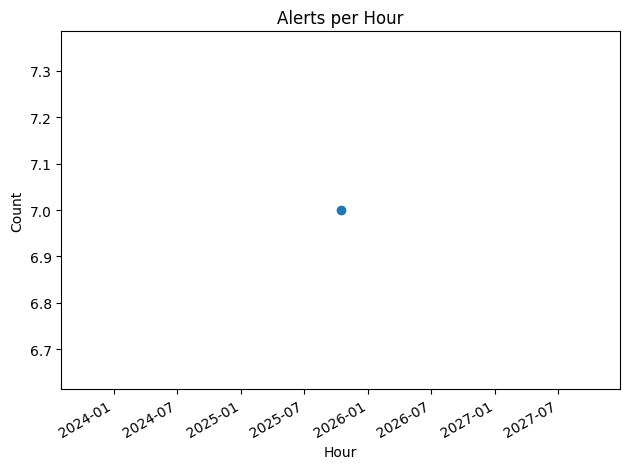

In [5]:

# === Visualization: Alerts per hour ===
if not df_alerts.empty and "start_dt" in df_alerts.columns:
    hourly = df_alerts["start_dt"].dt.floor("h").value_counts().sort_index()
    plt.figure()
    hourly.plot(kind="line", marker="o")
    plt.title("Alerts per Hour")
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for Alerts per Hour.")


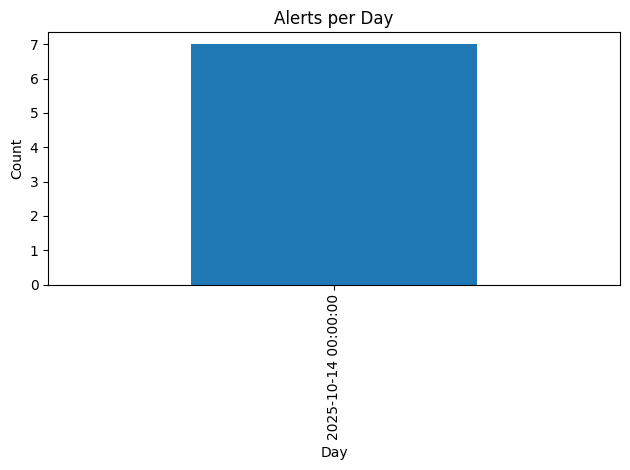

In [6]:
# Alerts per Day
ts = pd.to_datetime(df_alerts["start"])
per_day = ts.dt.floor("D").value_counts().sort_index()

plt.figure()
per_day.plot(kind="bar")
plt.title("Alerts per Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


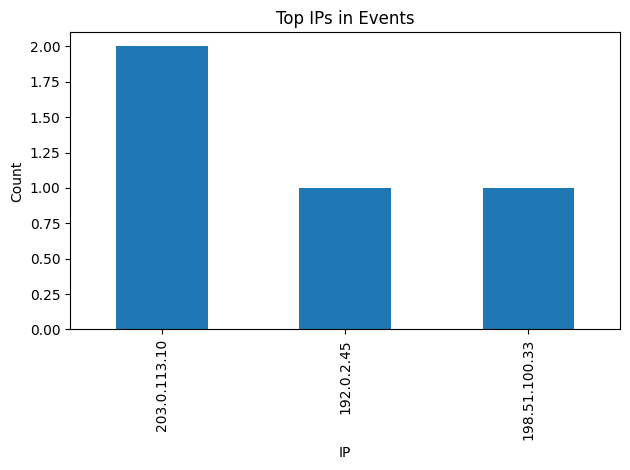

In [7]:

# === Visualization: Top IPs in events ===
if not df_events.empty and "ip" in df_events.columns:
    top = df_events["ip"].dropna().value_counts().head(10)
    plt.figure()
    top.plot(kind="bar")
    plt.title("Top IPs in Events")
    plt.xlabel("IP")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No IP column available in events.")


In [8]:

# === Optional: IP Origins (if present in alerts) ===
if "ip_origins" in df_alerts.columns:
    rows = []
    for _, r in df_alerts.iterrows():
        if isinstance(r.get("ip_origins"), list):
            for item in r["ip_origins"]:
                if isinstance(item, dict):
                    rows.append({
                        "rule": r.get("rule"),
                        "start": r.get("start"),
                        "ip": item.get("ip"),
                        "origin": item.get("origin")
                    })
    if rows:
        df_orig = pd.DataFrame(rows)
        display_dataframe_to_user("IP Origins (from alerts)", df_orig)
    else:
        print("No ip_origins data found in alerts.")
else:
    print("ip_origins column not present in alerts.")


,rule,start,ip,origin
0,failed_logins,2025-10-14T12:01:10,192.0.2.45,unknown
1,failed_logins,2025-10-14T12:01:10,203.0.113.10,unknown
2,failed_logins,2025-10-14T12:01:12,203.0.113.10,unknown
3,failed_logins,2025-10-14T12:01:15,203.0.113.10,unknown
4,failed_logins,2025-10-14T12:03:10,198.51.100.33,unknown
